In [48]:
import torch
import torch.nn as nn
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [49]:
import warnings
warnings.filterwarnings('ignore')

## Loading MNIST dataset

In [50]:
batch_size = 10

In [57]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [58]:
trainloader.dataset.train_data.shape, testloader.dataset.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [449]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = tuple(str(i) for i in range(10))

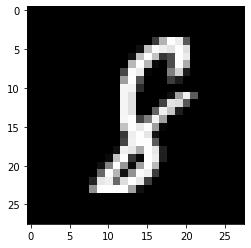

In [126]:
i = np.random.randint(low=0, high=60000)
plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray')
plt.show()

In [60]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [61]:
device

'cuda:0'

## Model parameters

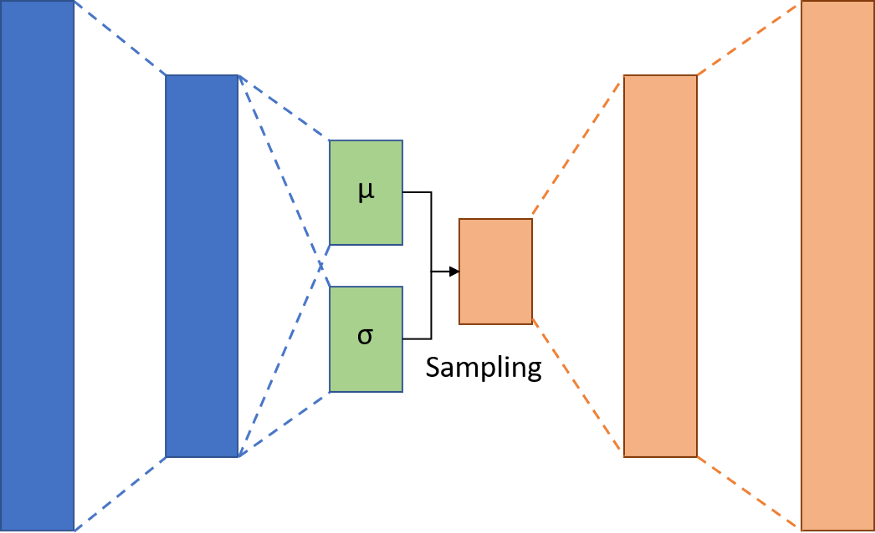

In [96]:
class VAE(nn.Module):
    def __init__(self, beta=1):
        super(VAE, self).__init__()
        self.hidden_size = 28
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(784,392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, self.hidden_size))
        
        self.hidden_mu = nn.Linear(self.hidden_size, self.hidden_size)
        self.hidden_log_var = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_size, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 784),
                                     #nn.Unflatten(),
                                     #reshape back to 28,28
                                     nn.Sigmoid())
        self.beta = beta # in case of disentangled VAE !=1 and is passed as a parameter
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden) # getting mu and sigma for reparametrization trick
        return mu, log_var

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        #z = std_normal.sample((sigma.size[0],self.hidden_size)) # TODO: fix the sample shape
        z = torch.randn_like(sigma) # get normal distribution size of sigma
        return sigma * z + mu
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 

### Loss function

In [97]:
def loss_fn(mu, log_var, x_out, x):
        kl_loss = (-0.5*( 1 + log_var - mu**2 - torch.exp(log_var)).sum(1)).mean(0)
        #recon_loss = std_normal.log_prob(x_out).sum(1).mean()/batch_size # x_out = z
        #recon_loss = self.distrN(mu, log_var).log_prob(x).sum(1).mean()/batch_size
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss + kl_loss
        return loss

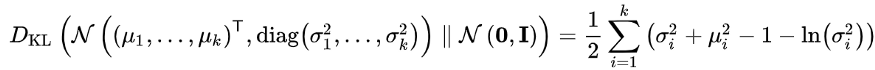

## Training

In [109]:
net = VAE()

In [110]:
optimizer = torch.optim.Adagrad(params = net.parameters())
#optimizer = torch.optim.Adam(params = net.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

In [111]:
train_loss=[]
test_loss = []
net.train(True)
for i, batch in enumerate(tqdm_notebook(trainloader)):   
    optimizer.zero_grad()

    x, _ = batch
    mu, log_var, x_out = net.forward(x)
    
    loss = loss_fn(mu, log_var, x_out.view((batch_size,28,28)), x)
    
    loss.backward()
    optimizer.step()

    train_loss.append(loss.detach().item())
    
    #net.train(False)
    #with torch.no_grad():
       # mu, log_var, x_out = net.forward(x)
       # test_loss.append(loss_fn(mu, log_var, x_out.reshape((batch_size,28,28)),x).item())

  0%|          | 0/6000 [00:00<?, ?it/s]

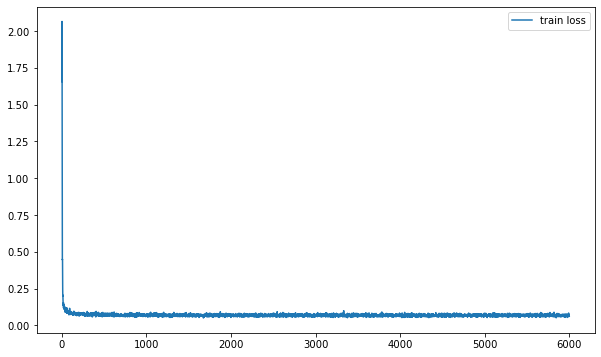

In [112]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
#plt.plot(np.arange(len(test_loss)), test_loss, label="test loss")
#plt.title("Losses")
#plt.ylim(0,1)
plt.legend()
plt.show()

## Testing

In [113]:
net.train(False)
for i, batch in enumerate(tqdm_notebook(testloader)):    
    with torch.no_grad():
        x, _ = batch
        mu, log_var, x_out = net.forward(x)
        loss = loss_fn(mu, log_var, x_out.reshape((batch_size,28,28)), x)

        test_loss.append(loss.detach().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

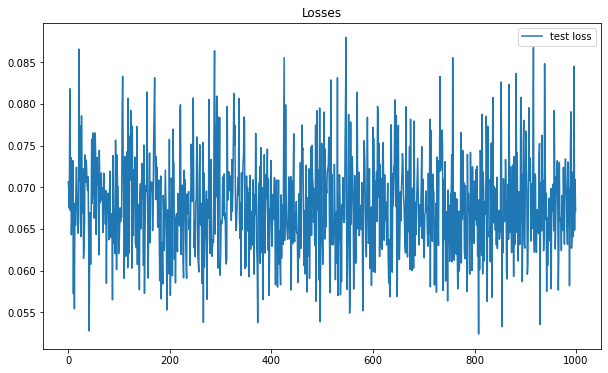

In [114]:
plt.figure(figsize=(10,6))
#plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
plt.plot(np.arange(len(test_loss)), test_loss, label="test loss")
plt.title("Losses")
#plt.ylim(0,1)
plt.legend()
plt.show()

In [115]:
# def imcheck(data, shape=(20,5)):
#     columns = shape[1]
#     rows = shape[0]
#     fig = plt.figure(figsize=(rows*4, columns*2))    
#     ax = []

#     for i in range(columns*rows):
#         img = x_out[i].detach().reshape((28,28)).numpy()
#         ax.append( fig.add_subplot(rows, columns, i+1) )
#         ax[-1].set_title("ax:"+str(i))
#         plt.imshow(img, cmap='gray')

#     plt.show()

In [116]:
iterator = iter(testloader)
x_batch, y_batch = iterator.next()
x_in = x_batch.squeeze(1)

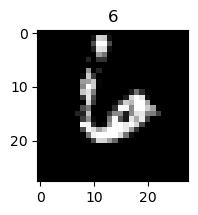

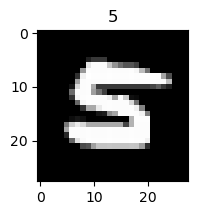

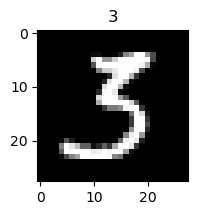

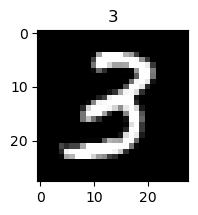

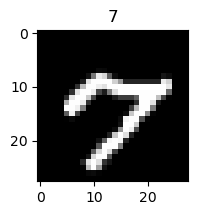

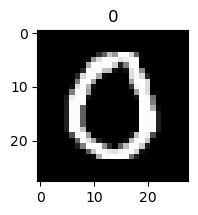

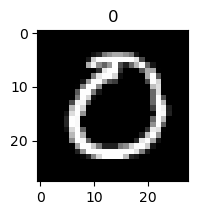

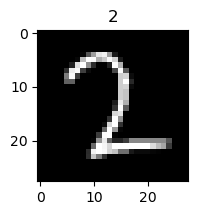

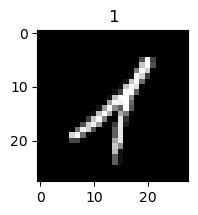

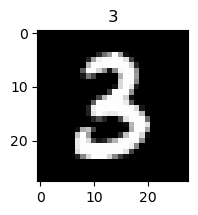

In [117]:
for i in range(batch_size):
    plt.figure(figsize=(2, 2), dpi=100)
    plt.title(str(y_batch[i].item()))
    plt.imshow(x_in[i].reshape((28,28)).numpy(), cmap='gray')
    plt.show()

In [118]:
with torch.no_grad():
    _, __, x_out = net.forward(x_in)

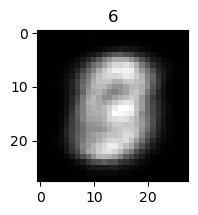

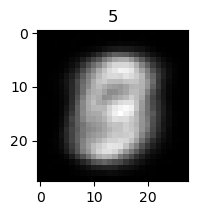

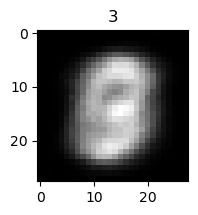

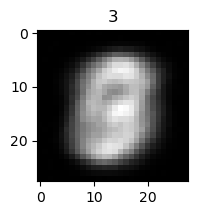

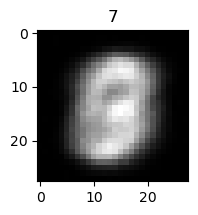

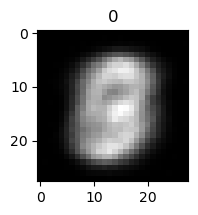

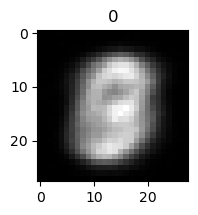

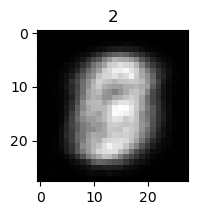

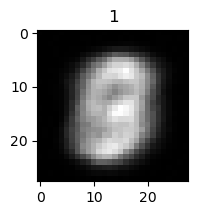

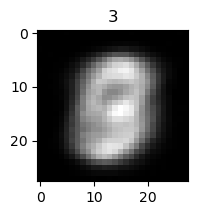

In [119]:
for i in range(batch_size):
    plt.figure(figsize=(2, 2), dpi=100)
    plt.title(str(y_batch[i].item()))
    plt.imshow(x_out[i].detach().reshape((28,28)).numpy(), cmap='gray')
    plt.show()